In [1]:
import mlflow.keras
import mlflow
import mlflow.tensorflow
import time
from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf

from table_functions import *
from analyze_visualisation import *
from ml_models.decision_tree import *
from ml_models.random_forest import *
from ml_models.xg_boost import *
from ml_models.neural_network_train import *
from ml_models.extra_random_forest import *
from ml_functions import *

In [2]:
# TO MUSI BYC USTAWIONE ZAWSZE TAK SAMO, a potem jak sie chce umieszczac dane modele w innym folderze to zmienia sie nazwe  artifact_directory = "other_classification"
# jak chce sie wlaczyc potem mlflow w przegladarce, trzeba w terminalu przejsc do lokalizacji 'src' i wpisac komende mlflow ui
current_working_directory = os.getcwd()
mlflow.set_tracking_uri(f"file://{os.path.join(current_working_directory, 'mlruns')}")

In [ ]:
# not normalized data
ml_data_nn = read_data_for_traning('n_n_lwd')

In [ ]:
# normalized in range 0-1
ml_data_0_1 = read_data_for_traning('0_1_lwd')

In [ ]:
# standard normalized
ml_data_ss = read_data_for_traning('s_s_lwd')

In [ ]:
ml_data_nn.keys()

In [4]:
ml_data_dgm9 = read_data_for_traning('dgm9_9')
ml_data_dgm10 = read_data_for_traning('dgm10_10')

File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_train_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_valid_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_test_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/y_train_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/y_valid_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/y_test_dgm9_9.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_train_dgm10_10.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_valid_dgm10_10.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/x_test_dgm10_10.csv
File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/me

<h4>Drzewo decyzyjne</h4>

In [ ]:
clf = decision_tree_model(*ml_data_ss.values(), run_name_="normal_run")

<h4>Las losowy<h4>

In [ ]:
clf = random_forest_model(*ml_data_ss.values(), run_name_="only_4_columns_1")

<h4>XGBoost</h4>

2024/01/25 15:40:32 INFO mlflow.tracking.fluent: Experiment with name 'dgm9' does not exist. Creating a new experiment.
2024/01/25 15:40:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/01/25 15:40:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4a6c3adacc774c01bebf8807572dab21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\sk

[0]	validation_0-auc:0.65155
[1]	validation_0-auc:0.68702
[2]	validation_0-auc:0.71142
[3]	validation_0-auc:0.71374
[4]	validation_0-auc:0.71389
[5]	validation_0-auc:0.71902
[6]	validation_0-auc:0.72085
[7]	validation_0-auc:0.72437
[8]	validation_0-auc:0.72367
[9]	validation_0-auc:0.72620
[10]	validation_0-auc:0.72703
[11]	validation_0-auc:0.73153
[12]	validation_0-auc:0.73552
[13]	validation_0-auc:0.73659
[14]	validation_0-auc:0.74259
[15]	validation_0-auc:0.74240
[16]	validation_0-auc:0.74271
[17]	validation_0-auc:0.74183
[18]	validation_0-auc:0.74262
[19]	validation_0-auc:0.74498
[20]	validation_0-auc:0.74473
[21]	validation_0-auc:0.74458
[22]	validation_0-auc:0.74501
[23]	validation_0-auc:0.74576
[24]	validation_0-auc:0.74604
[25]	validation_0-auc:0.74625
[26]	validation_0-auc:0.74658
[27]	validation_0-auc:0.74653
[28]	validation_0-auc:0.74768
[29]	validation_0-auc:0.74761
[30]	validation_0-auc:0.74791
[31]	validation_0-auc:0.74794
[32]	validation_0-auc:0.74797
[33]	validation_0-au

2024/01/25 15:41:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/01/25 15:41:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/01/25 15:41:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost

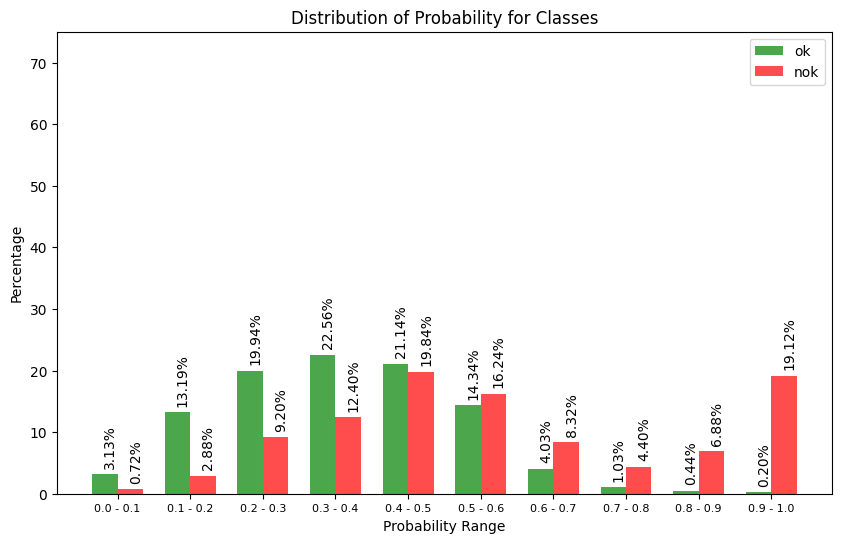

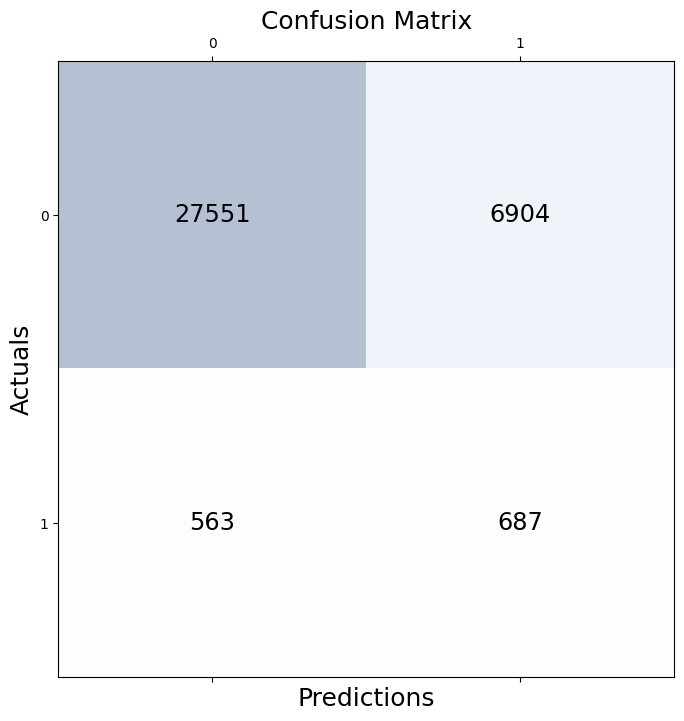

In [5]:
clf_dgm9 = xgb_model(*ml_data_dgm9.values(), run_name_="dgm9")

2024/01/25 15:41:22 INFO mlflow.tracking.fluent: Experiment with name 'dgm10' does not exist. Creating a new experiment.
2024/01/25 15:41:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/01/25 15:41:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b53e27b375d945d3a7baff24243e41fc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\s

[0]	validation_0-auc:0.74237
[1]	validation_0-auc:0.75454
[2]	validation_0-auc:0.76285
[3]	validation_0-auc:0.76578
[4]	validation_0-auc:0.76811
[5]	validation_0-auc:0.77030
[6]	validation_0-auc:0.77093
[7]	validation_0-auc:0.77187
[8]	validation_0-auc:0.77515
[9]	validation_0-auc:0.77556
[10]	validation_0-auc:0.77570
[11]	validation_0-auc:0.77648
[12]	validation_0-auc:0.77774
[13]	validation_0-auc:0.78283
[14]	validation_0-auc:0.78399
[15]	validation_0-auc:0.78442
[16]	validation_0-auc:0.78417
[17]	validation_0-auc:0.78482
[18]	validation_0-auc:0.78642
[19]	validation_0-auc:0.78689
[20]	validation_0-auc:0.78802
[21]	validation_0-auc:0.78889
[22]	validation_0-auc:0.78803
[23]	validation_0-auc:0.78847
[24]	validation_0-auc:0.78830
[25]	validation_0-auc:0.78841
[26]	validation_0-auc:0.78960
[27]	validation_0-auc:0.78984
[28]	validation_0-auc:0.78942
[29]	validation_0-auc:0.78886
[30]	validation_0-auc:0.78870
[31]	validation_0-auc:0.78918
[32]	validation_0-auc:0.78848
[33]	validation_0-au

2024/01/25 15:41:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/01/25 15:42:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. 

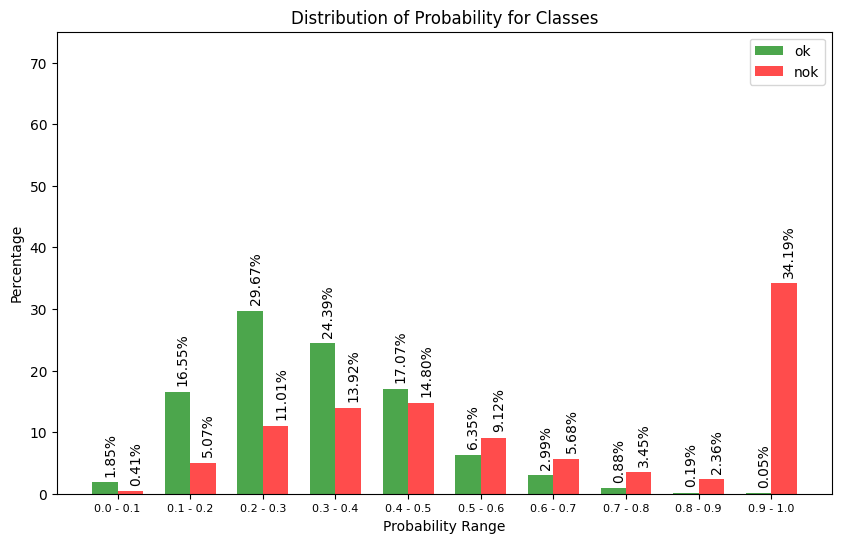

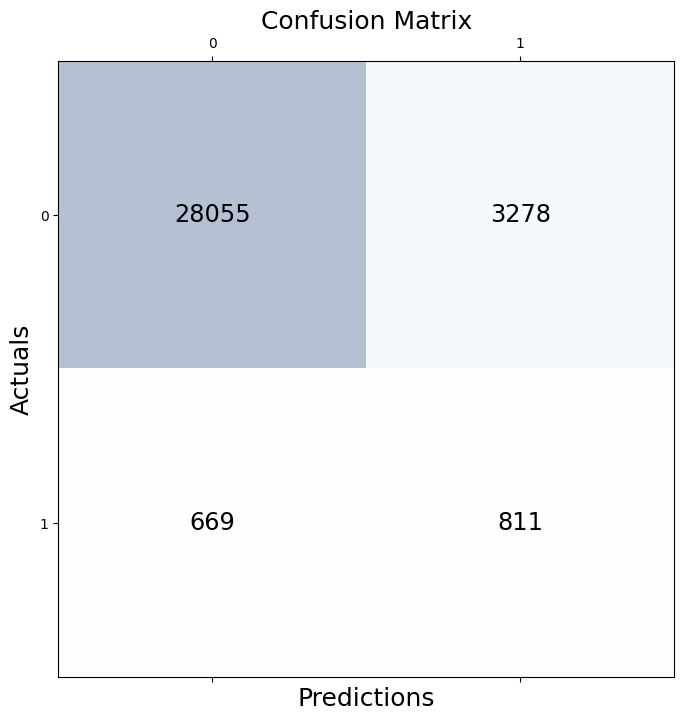

In [6]:
clf_dgm10 = xgb_model(*ml_data_dgm10.values(), run_name_="dgm10")

<h4>Sieci neuronowe<h4>

In [ ]:
compile_fit_evaluate_model(*ml_data_ss.values(), epochs_=5, batch_size_=64, model_number=0, run_name_=f"run_ss_test_15")

In [ ]:
ml_data_ss['y_train'].head()

In [ ]:
print(ml_data_ss['y_train']['our_final_status'].unique())
print(ml_data_ss['y_test']['our_final_status'].unique())
print(ml_data_ss['y_valid']['our_final_status'].unique())

In [ ]:
ml_data_ss['y_test']['our_final_status'].unique()

In [ ]:
ml_data_ss['x_train'].shape

In [ ]:
ml_data_ss['x_train'].describe()

In [ ]:
m = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.5, class_id=0)
m.update_state([0, 0, 0, 1, 1], [0, 0.3, 0.3, 0.8, 0.4])
specificity = m.result().numpy()

print(f"Specificity at sensitivity 0.5 for class '1': {specificity}")


<h4>Super drzewa losowe</h4>

In [ ]:
clf = extra_random_trees(*ml_data_ss.values(), run_name_="first_run")

<h4>Cross Validacja</h4>

Według mnie na razie zostawmy cross validacje w spokoju, na normalnym zbiorze znajdzmy najlepsze parametry dla modeli a potem dopiero zrobmy na takich parametrach cross validacje by zobaczyc 'prawdziwa' jakosc modelu
PS. ponizszy kod wykonuje sie jakas 1h
PS2. dane sie zapisaly ale jakis syf

In [ ]:
artifact_directory="cv_random_forest"
mlflow.set_experiment(artifact_directory)
mlflow.sklearn.autolog()

with start_run(run_name="testowy run"):
    clf = RandomForestClassifier(random_state=0)
    scores = cross_val_score(estimator=clf, X=ml_data_ss['x_train'], y=ml_data_ss['y_train'], cv=5)
print(scores)
# [0.99786842 0.99779825 0.99742105 0.99770175 0.99797368] - wynik

In [ ]:
loaded_model = mlflow.keras.load_model(r'file://C:\Users\dlxpmx8\Desktop\Projekt_AI\meb_process_data_analysis\src\mlruns/386163800829212723/5e018f9f70514ad889d242edd0430b67/artifacts/model')

In [ ]:
distribution_of_probability(ml_data['x_test'], ml_data['y_test'], model_=loaded_model)

In [ ]:
model2 = xgb.XGBClassifier()
model2.load_model(r"c:\Users\Administrator\Desktop\meb_process_data_analysis\src\mlruns/348484781179021161/036ad3b7c6ff4806ace76162289c8eb4/artifacts/model")